# Analysis of Cirrhosis patients

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,2178.0,D-penicillamine,16374.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0,C
1,1,2644.0,D-penicillamine,17774.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0,C
2,2,3069.0,Placebo,17844.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0,C
3,3,2216.0,Placebo,19221.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0,C
4,4,2256.0,Placebo,21600.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0,D


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8494 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8502 non-null   object 
 6   Hepatomegaly   8492 non-null   object 
 7   Spiders        8491 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6701 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8399 non-null   float64
 13  Alk_Phos       8488 non-null   float64
 14  SGOT           8486 non-null   float64
 15  Tryglicerides  6666 non-null   float64
 16  Platelets      14436 non-null  float64
 17  Prothrombin    14984 non-null  float64
 18  Stage 

We can see that we have a lot of missing values. We will have to account for this in our preprocessing pipeline. We cannot drop the rows with missing columns becaause the data loss will be huge. That's why we will fill them with the mean(for numerical) and most frequent(for categorical) values. 

In [4]:
df["Status"].value_counts()

Status
C     10053
D      4565
CL      381
Y         1
Name: count, dtype: int64

There seems to be one entry where Status is 'Y', which is not expected at all, so we are dropping this row.

In [5]:
df = df[df['Status']!='Y']
df["Status"].value_counts()

Status
C     10053
D      4565
CL      381
Name: count, dtype: int64

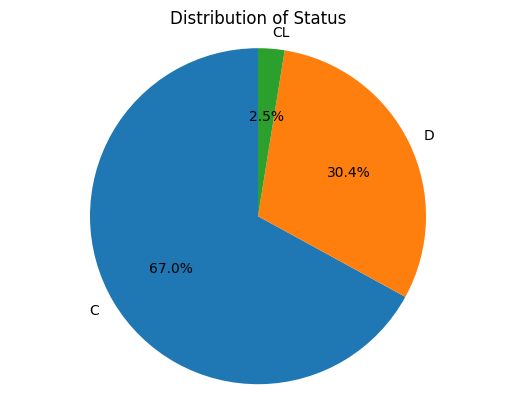

In [6]:
df['Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='')
plt.title('Distribution of Status')
plt.axis('equal')  # ensures it's a circle
plt.show()

<Axes: xlabel='Status', ylabel='Bilirubin'>

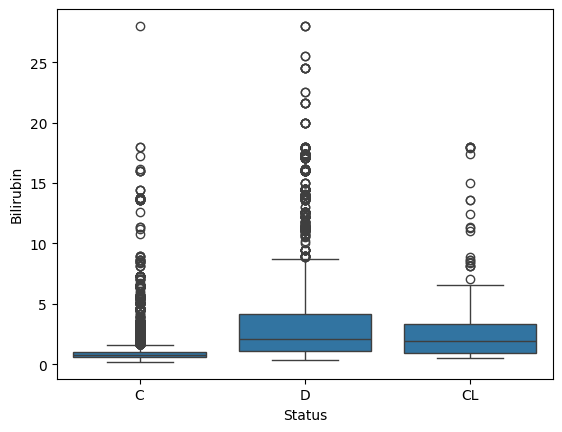

In [7]:
sns.boxplot(data=df, x='Status', y='Bilirubin')

<Axes: xlabel='Status', ylabel='Albumin'>

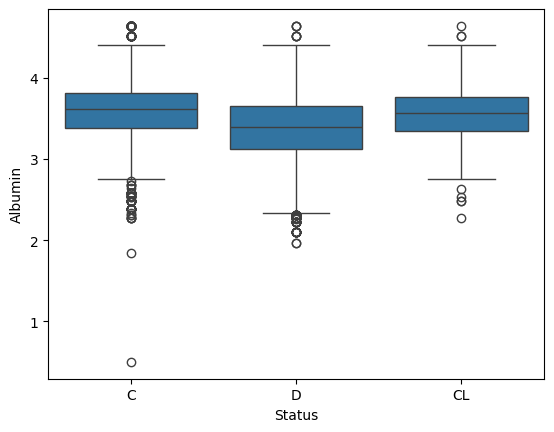

In [8]:
sns.boxplot(data=df, x='Status', y='Albumin')

<Axes: xlabel='Status', ylabel='Cholesterol'>

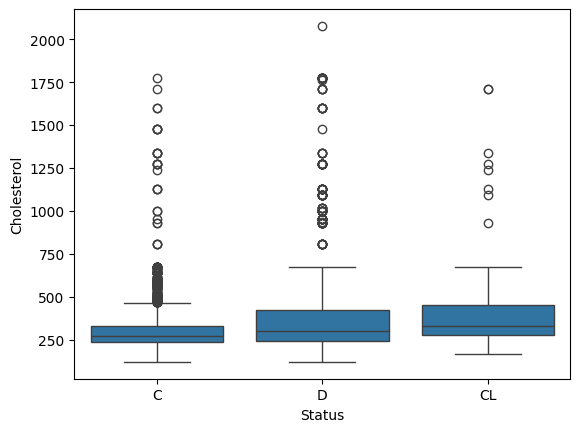

In [9]:
sns.boxplot(data=df, x='Status', y='Cholesterol')

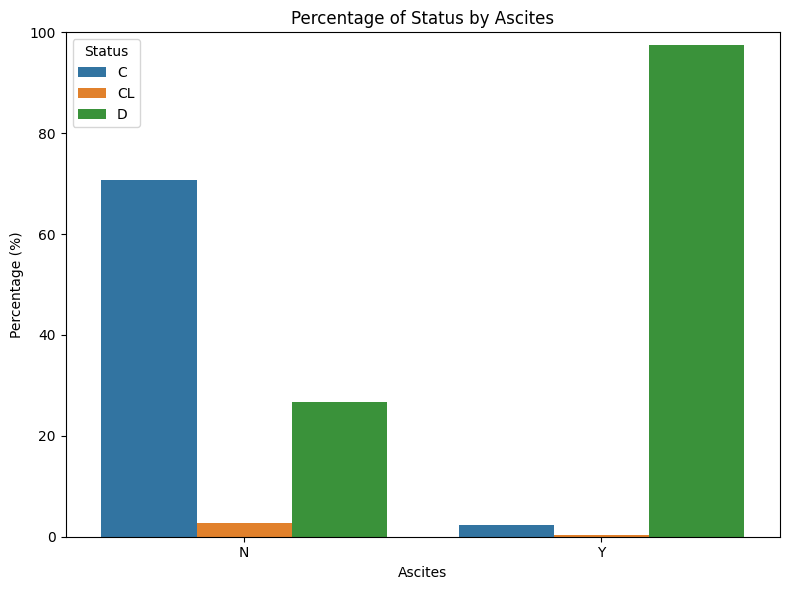

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to valid values
df_filtered = df[df['Status'].isin(['C', 'CL', 'D']) & df['Ascites'].isin(['N', 'Y'])]

# Count occurrences
group_counts = df_filtered.groupby(['Ascites', 'Status']).size().reset_index(name='Count')

# Calculate percentage within each Ascites group
group_counts['Percentage'] = group_counts.groupby('Ascites')['Count'].transform(lambda x: 100 * x / x.sum())

# Plot percentage bars
plt.figure(figsize=(8, 6))
sns.barplot(data=group_counts, x='Ascites', y='Percentage', hue='Status')

plt.title('Percentage of Status by Ascites')
plt.ylabel('Percentage (%)')
plt.xlabel('Ascites')
plt.ylim(0, 100)
plt.legend(title='Status')
plt.tight_layout()
plt.show()


In [11]:
X = df.drop(columns=['Status'])
y = df['Status']

In [12]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [16]:
# Preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('Standardizer', StandardScaler())]
    )
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [17]:
X = preprocessor.fit_transform(X)

In [24]:
le = LabelEncoder()
y = le.fit_transform(y)

In [18]:
model = LogisticRegression(multi_class='multinomial',
        solver='saga',       # saga handles large sparse data well
        max_iter=2000,       # bump up from default 100
        C=1.0,               # regularization strength
        n_jobs=-1,
        random_state=0)
model.fit(X, y)

LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=-1,
                   random_state=0, solver='saga')

In [19]:
classes = model.classes_
classes

array(['C', 'CL', 'D'], dtype=object)

In [20]:
predictions = model.predict_proba(X)
predictions.shape

(14999, 3)

In [25]:
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=2000)),
    ('SVM', SVC(probability=True, kernel='rbf', class_weight='balanced', C=1.0)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=9, class_weight='balanced', random_state=42)),
    ('XGBoost', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, eval_metric='logloss', scale_pos_weight=3, use_label_encoder=False)),
    ('CatBoost', CatBoostClassifier(verbose=0, iterations=100, learning_rate=0.1, depth=4, random_state=42)),
    ('Gradient Boost', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# Use log_loss as a scoring function (note: cross_val_score maximizes scores, so log loss must be negated)
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

for name, model in models:
    scores = cross_val_score(model, X, y, cv=10, scoring=log_loss_scorer)
    print(f"{name}: Mean Log Loss = {-scores.mean():.4f}, Std = {scores.std():.4f}")


Logistic Regression: Mean Log Loss = 0.7418, Std = 0.0206
SVM: Mean Log Loss = 0.4446, Std = 0.0132
Random Forest: Mean Log Loss = 0.5485, Std = 0.0154


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pa

XGBoost: Mean Log Loss = 0.3963, Std = 0.0261
CatBoost: Mean Log Loss = 0.4052, Std = 0.0131
Gradient Boost: Mean Log Loss = 0.5789, Std = 0.3800
